In [ ]:
import os
import argparse
import nibabel as nib
import dipy as dp
from nibabel.streamlines import Field
from nibabel.orientations import aff2axcodes
from dipy.viz import fvtk
from dipy.segment.bundles import RecoBundles

from dipy.segment.metric import ResampleFeature
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from dipy.segment.metric import CenterOfMassFeature
from dipy.segment.metric import EuclideanMetric
from dipy.segment.metric import IdentityFeature
from dipy.segment.clustering import QuickBundles
from dipy.viz import actor, window
from dipy.io.image import load_nifti, save_nifti
import numpy as np

from time import sleep
from dipy.align.streamlinear import StreamlineLinearRegistration
from dipy.tracking.streamline import transform_streamlines
from dipy.tracking.streamline import set_number_of_points
from scipy.interpolate import griddata,RegularGridInterpolator
import matplotlib.pyplot as plt
from dipy.tracking import utils

from scipy import stats
from dipy.io.streamline import load_trk, save_trk
from dipy.tracking.streamline import Streamlines
import statsmodels.stats.multitest as mt

In [ ]:
NAS="dumbo"
protocole="strokconnect"
DIR_PATH="/NAS/"+NAS+"/protocoles/"+protocole
FS_PATH=DIR_PATH+"/FS53/"
SUBJECT="AUMONT^SEBASTIEN_I_CERE_2014-08-12" #"DE_RIEMAECKER^HENRI_I_CERE_2015-09-08"
TCK_LOCATION=FS_PATH+SUBJECT+'''/dti/'''
all_list=['AUMONT^SEBASTIEN_I_CERE_2014-08-12','BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10','BERTELOOT^DAMIEN_I_CERE_2015-03-17','BERTELOOT^PATRICE_I_CERE_2015-09-08','BLANC^HELENE_I_CERE_2014-12-18','BOUMLIK^SAID_I_CERE_2014-09-03','BOURDON^PAULETTE_I_CERE_2015-01-21','CARPENTIER^SANDRA_I_CERE_2014-11-28','CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29','DAVELUY^WALTER_stroke_connect_2015-04-27','DE_RIEMAECKER^HENRI_I_CERE_2015-09-08','DIAS^ANTHONY_I_CERE_2015-10-20','DJEMAI^ALI_I_CERE_2015-11-16','EZELIN^ERIC_IRM_CEREBRALE_2014-12-10','FACON^PASCALE_I_CERE_2014-12-19','GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13','HEMARD^VERONIQUE_I_CERE_2016-02-24','HERBIN^GERARD_I_CERE_2015-07-02','KOLLIKER^ALAIN_IRM_CEREBRALE_2016-02-24','KOPCIUCH^FRANCOIS_I_CERE_2015-06-10','Le_Nestour_Christian_2015-07-07','NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05','NOYON^THADEE_I_CERE_2015-07-03','VANRENTERGHEM^DAVID_I_CERE_2015-10-06','VANTORRE^MICHELE_I_CERE_2015-09-25','VANTORRE^PIERRE_I_CERE_2015-09-25']
pts_list=['AUMONT^SEBASTIEN_I_CERE_2014-08-12','BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10','BOUMLIK^SAID_I_CERE_2014-09-03','CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29','DE_RIEMAECKER^HENRI_I_CERE_2015-09-08','DIAS^ANTHONY_I_CERE_2015-10-20','FACON^PASCALE_I_CERE_2014-12-19','GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13','HERBIN^GERARD_I_CERE_2015-07-02','NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05','NOYON^THADEE_I_CERE_2015-07-03','VANRENTERGHEM^DAVID_I_CERE_2015-10-06']#,'HEMARD^VERONIQUE_I_CERE_2016-02-24',
Cloches=[0,0,2,9,0,2,7,8,3,4,6,0]
ECB=[0,0,0,9,0,0,11,7,2,5,4,0]
Fluff=[15,15,14,13,15,15,10,14,14,12,15,15]
FuflMeyer=[33,59,59,7,33,23,24,11,38,60,6,62]

ctrls_list=['BERTELOOT^DAMIEN_I_CERE_2015-03-17','BERTELOOT^PATRICE_I_CERE_2015-09-08','BLANC^HELENE_I_CERE_2014-12-18','BOURDON^PAULETTE_I_CERE_2015-01-21','CARPENTIER^SANDRA_I_CERE_2014-11-28','DAVELUY^WALTER_stroke_connect_2015-04-27','DJEMAI^ALI_I_CERE_2015-11-16','EZELIN^ERIC_IRM_CEREBRALE_2014-12-10','KOLLIKER^ALAIN_IRM_CEREBRALE_2016-02-24','KOPCIUCH^FRANCOIS_I_CERE_2015-06-10','Le_Nestour_Christian_2015-07-07','VANTORRE^MICHELE_I_CERE_2015-09-25','VANTORRE^PIERRE_I_CERE_2015-09-25']
print(len(ctrls_list))
print(len(pts_list))
print(len(all_list))

for i,j,k,l,m in zip(pts_list,Cloches,ECB,Fluff,FuflMeyer):
    print i,j,k,l,m


In [ ]:
print(TCK_LOCATION+"whole_brain_1500000.dpy")
dpw = dp.io.dpy.Dpy(TCK_LOCATION+"whole_brain_1500000.dpy", 'w')

for root, dirs, files in os.walk("/NAS/dumbo/protocoles/strokconnect/QA_DTI/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/"):    
    for file in files:
        if file.startswith('whole_brain_6_1500000_part') :
            print(file)
            bundle = nib.streamlines.load(root+file)
            dpw.write_tracks(bundle.streamlines)

dpw.close()

le code ci-dessous va rassembler les fichiers tck/trk d'un bundle dans un fichier dpy
(avant j'ai utilisé BundleSeg afin de créer les fichiers tck/trk cf. fichier runBatch.sh) 

In [25]:
for SUBJECT in pts_list:
    TCK_LOCATION=FS_PATH+SUBJECT+'''/dti/'''
#['extreme_capsule.left','extreme_capsule.right','internal_capsule_new.left','internal_capsule_new.right','slf_i.left','slf_i.right','ioff.left','ioff.right','soff.left','soff.right','mdlf.left','mdlf.right','ec.left','ec.right','cb.left','cb.right','cst.left','cst.right','thalamo_frontal.left','thalamo_frontal.right','thalamo_occipital.left','thalamo_occipital.right','thalamo_parietal.left','thalamo_parietal.right','uf.left','uf.right','af.left','af.right','cc_1','cc_2','cc_3','cc_4','cc_7','ilf.left','ilf.right','internal_capsule_new.left','slf_iii.left','slf_iii.right','slf_ii.left','slf_ii.right','striato_frontal.left','striato_frontal.right','striato_occipital.left','striato_occipital.right','striato_parietal.left','striato_parietal.right']:
    for STR_FX in ['cc_parietal']:
        #print(TCK_LOCATION+STR_FX+".dpy")
        #if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
        #    os.remove(TCK_LOCATION+STR_FX+".dpy")
        dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'w')                
        for root, dirs, files in os.walk(TCK_LOCATION):    
            for file in files:
                if file.startswith('whole_brain_6_1500000_part') & file.endswith(STR_FX+'.trk'):
                    bundle = nib.streamlines.load(root+file)
                    dpw.write_tracks(bundle.streamlines)
                    os.remove(root+file)
        dpw.close()

## Visu bundle associatif (b)

In [7]:
ren = window.ren()
SUBJECT='AUMONT^SEBASTIEN_I_CERE_2014-08-12'#'DE_RIEMAECKER^HENRI_I_CERE_2015-09-08'#'BERTELOOT^DAMIEN_I_CERE_2015-03-17'
TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''  
data, affine = load_nifti(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz")
STR_FX='slf_i.left'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.red,linewidth=0.1))     
STR_FX='slf_ii.left'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.green,linewidth=0.1)) 
STR_FX='slf_iii.left'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.blue,linewidth=0.1)) 
STR_FX='slf_i.right'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.red,linewidth=0.1))     
STR_FX='slf_ii.right'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.green,linewidth=0.1)) 
STR_FX='slf_iii.right'
dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
tracks=dpw.read_tracks();
tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
ren.add(actor.line(tracks_onFA,window.colors.blue,linewidth=0.1)) 

STR_FX='cc_parietal'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.white,linewidth=0.1))  
    
surface_opacity = 0.3
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
#ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
#fvtk.add(ren,fvtk.axes())
window.show(ren)

# Pipeline c

In [25]:
feature = ResampleFeature(nb_points=200)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1

SUBJECT='AUMONT^SEBASTIEN_I_CERE_2014-08-12'#'DE_RIEMAECKER^HENRI_I_CERE_2015-09-08'#'BERTELOOT^DAMIEN_I_CERE_2015-03-17'
TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''  
data, affine = load_nifti(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz")

width=0.2
opac=0.5

ren = window.ren()
STR_FX='whole_cc_parietal'
bundle = nib.streamlines.load(FS_PATH+STR_FX+".trk")
ren.add(actor.line(bundle.streamlines,window.colors.white,linewidth=width,opacity=opac)) 
cluster_native = qb.cluster(bundle.streamlines)  
#ren.add(actor.line(cluster_native.centroids,window.colors.white,linewidth=10)) 

STR_FX='whole_slf_i.left'
bundle = nib.streamlines.load(FS_PATH+STR_FX+".trk")
ren.add(actor.line(bundle.streamlines,window.colors.red,linewidth=width,opacity=opac)) 
cluster_native = qb.cluster(bundle.streamlines)  
#ren.add(actor.line(cluster_native.centroids,window.colors.red,linewidth=10)) 

STR_FX='whole_slf_i.right'
bundle = nib.streamlines.load(FS_PATH+STR_FX+".trk")
ren.add(actor.line(bundle.streamlines,window.colors.red,linewidth=width,opacity=opac)) 
cluster_native = qb.cluster(bundle.streamlines)  
#ren.add(actor.line(cluster_native.centroids,window.colors.red,linewidth=10)) 

STR_FX='whole_slf_ii.left'
bundle = nib.streamlines.load(FS_PATH+STR_FX+".trk")
ren.add(actor.line(bundle.streamlines,window.colors.green,linewidth=width,opacity=opac)) 
cluster_native = qb.cluster(bundle.streamlines)  
#ren.add(actor.line(cluster_native.centroids,window.colors.green,linewidth=10)) 

STR_FX='whole_slf_ii.right'
bundle = nib.streamlines.load(FS_PATH+STR_FX+".trk")
ren.add(actor.line(bundle.streamlines,window.colors.green,linewidth=width,opacity=opac)) 
cluster_native = qb.cluster(bundle.streamlines)  
#ren.add(actor.line(cluster_native.centroids,window.colors.green,linewidth=10)) 

STR_FX='whole_slf_iii.left'
bundle = nib.streamlines.load(FS_PATH+STR_FX+".trk")
ren.add(actor.line(bundle.streamlines,window.colors.blue,linewidth=width,opacity=opac)) 
cluster_native = qb.cluster(bundle.streamlines)  
#ren.add(actor.line(cluster_native.centroids,window.colors.blue,linewidth=10)) 

STR_FX='whole_slf_iii.right'
bundle = nib.streamlines.load(FS_PATH+STR_FX+".trk")
ren.add(actor.line(bundle.streamlines,window.colors.blue,linewidth=width,opacity=opac)) 
cluster_native = qb.cluster(bundle.streamlines)  
#ren.add(actor.line(cluster_native.centroids,window.colors.blue,linewidth=10)) 

surface_opacity = 0.3
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
#ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))

window.show(ren)

In [8]:
surface_opacity = 0.3
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
fvtk.add(ren,fvtk.axes())
window.show(ren)

## Visu bundle commisural

In [297]:
ren = window.ren()
SUBJECT='DIAS^ANTHONY_I_CERE_2015-10-20'
TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''  
data, affine = load_nifti(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz")  
STR_FX='cc_1'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.green,linewidth=0.1)) 
STR_FX='cc_2'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.blue,linewidth=0.1)) 
STR_FX='cc_3'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):    
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.red,linewidth=0.1))     
STR_FX='cc_4'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.yellow,linewidth=0.1)) 
STR_FX='cc_5'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.magenta,linewidth=0.1)) 
STR_FX='cc_6'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.pink,linewidth=1)) 
STR_FX='cc_7'
if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
    dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
    tracks=dpw.read_tracks();
    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
    ren.add(actor.line(tracks_onFA,window.colors.white,linewidth=0.1))  
surface_opacity = 0.3
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
fvtk.add(ren,fvtk.axes())
window.show(ren)

FileNotFoundError: No such file: '/NAS/dumbo/protocoles/strokconnect/FS53/DIAS^ANTHONY_I_CERE_2015-10-20/mri/raparc+aseg.nii.gz'

## Visu en boucle sur patient et tracks

In [12]:
feature = ResampleFeature(nb_points=200)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1

for SUBJECT in ['AUMONT^SEBASTIEN_I_CERE_2014-08-12']: #,'BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10','BERTELOOT^DAMIEN_I_CERE_2015-03-17','BERTELOOT^PATRICE_I_CERE_2015-09-08','BLANC^HELENE_I_CERE_2014-12-18','BOUMLIK^SAID_I_CERE_2014-09-03','BOURDON^PAULETTE_I_CERE_2015-01-21','CARPENTIER^SANDRA_I_CERE_2014-11-28','CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29','DAVELUY^WALTER_stroke_connect_2015-04-27','DE_RIEMAECKER^HENRI_I_CERE_2015-09-08','DIAS^ANTHONY_I_CERE_2015-10-20','DJEMAI^ALI_I_CERE_2015-11-16','EZELIN^ERIC_IRM_CEREBRALE_2014-12-10','FACON^PASCALE_I_CERE_2014-12-19','GOSSEIN^JEAN_PIERRE_I_CERE_2014-08-13','HEMARD^VERONIQUE_I_CERE_2016-02-24','HERBIN^GERARD_I_CERE_2015-07-02','KOLLIKER^ALAIN_IRM_CEREBRALE_2016-02-24','KOPCIUCH^FRANCOIS_I_CERE_2015-06-10','Le_Nestour_Christian_2015-07-07','NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05','NOYON^THADEE_I_CERE_2015-07-03','VANRENTERGHEM^DAVID_I_CERE_2015-10-06','VANTORRE^MICHELE_I_CERE_2015-09-25','VANTORRE^PIERRE_I_CERE_2015-09-25']:
    #SUBJECT='BERTELOOT^DAMIEN_I_CERE_2015-03-17'
    TCK_LOCATION=FS_PATH+SUBJECT+'''/dti/'''  
    if os.path.exists(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz") & os.path.exists(TCK_LOCATION+"dti_finalcor_FA.nii"):
        nii = nib.load(TCK_LOCATION+"dti_finalcor_FA.nii")
        data, affine = load_nifti(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz")
    #'ioff.left','slf_i.right','slf_ii.right','slf_iii.right','ioff.right','cc_1','cc_2','cc_3','cc_4','cc_5','cc_6','cc_7',
        ren = window.ren()
        for STR_FX in ['cc_parietal','slf_i.left','slf_ii.left','slf_iii.left']:
            if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
                dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
                tracks=dpw.read_tracks();
                print(SUBJECT+" "+STR_FX +" "+str(len(tracks)))                 
                if (len(tracks)>0):
                    tracks_onFA = transform_streamlines(tracks, np.linalg.inv(affine))
                    ren.add(actor.line(tracks_onFA,window.colors.red,linewidth=0.1,opacity=0.1))                                              
                    cluster = qb.cluster(tracks)
                    #ren.add(actor.line(cluster.centroids,window.colors.red,linewidth=10))
                    cluster_native = transform_streamlines(cluster.centroids, np.linalg.inv(affine))
                    data=nii.get_data()
                    ren.add(actor.line(cluster_native,nii.get_data(),linewidth=1))
                    surface_opacity = 0.3
                    surface_color = [0.75, 0.75, 0.75]
                    v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
                    ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
                    fvtk.add(ren,fvtk.axes())
            else :
                print(SUBJECT+" "+STR_FX +" No tracks")
        window.show(ren)


AUMONT^SEBASTIEN_I_CERE_2014-08-12 cc_parietal 2730
AUMONT^SEBASTIEN_I_CERE_2014-08-12 slf_i.left 27
AUMONT^SEBASTIEN_I_CERE_2014-08-12 slf_ii.left 3181
AUMONT^SEBASTIEN_I_CERE_2014-08-12 slf_iii.left 867


# Avec un recalage linenaire dans atlas

In [77]:
feature = ResampleFeature(nb_points=200)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1
    
streams, hdr = load_trk('/home/romain/Téléchargements/tracks/association/SLF_L.trk.gz')
fix_tracks = Streamlines(streams)
fix_tracks = set_number_of_points(fix_tracks, 20)

srr = StreamlineLinearRegistration()
ren = window.ren()
ren.add(actor.line(fix_tracks,window.colors.white,linewidth=0.1))
wholeTracks = []

for STR_FX in ['cc_parietal']:    
    for SUBJECT in pts_list:
        TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''
        if os.path.exists(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz") & os.path.exists(TCK_LOCATION+"dti_finalcor_FA.nii"):
            nii = nib.load(TCK_LOCATION+"dti_finalcor_FA.nii")
            data, affine = load_nifti(FS_PATH+SUBJECT+"/mri/raparc+aseg.nii.gz")
            if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
                dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
                tracks=dpw.read_tracks();
                print(SUBJECT+" "+STR_FX +" "+str(len(tracks)))                   
                if (len(tracks)>0):
                    tracks = set_number_of_points(tracks, 20)                    
                    srm = srr.optimize(static=fix_tracks, moving=tracks)
                    tracks_aligned = srm.transform(tracks)                    
                    for s in tracks_aligned:
                        wholeTracks.append(s)                                                                                           
            else :
                print(SUBJECT+" "+STR_FX +" No tracks")
ren.add(actor.line(wholeTracks,window.colors.blue,linewidth=0.1))                                                                                                 
cluster_aligned = qb.cluster(wholeTracks)   
ren.add(actor.line(cluster_aligned.centroids,window.colors.green,linewidth=1))                                                                                                 

window.show(ren)

AUMONT^SEBASTIEN_I_CERE_2014-08-12 cc_parietal 2730
BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10 cc_parietal 853
BOUMLIK^SAID_I_CERE_2014-09-03 cc_parietal 474
CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29 cc_parietal 2472
DE_RIEMAECKER^HENRI_I_CERE_2015-09-08 cc_parietal 1176
HERBIN^GERARD_I_CERE_2015-07-02 cc_parietal 496
NORO^JEAN_NOEL_STROKE_CONNECT_2015-06-05 cc_parietal 1980
NOYON^THADEE_I_CERE_2015-07-03 cc_parietal 935


In [257]:
#dpw = dp.io.dpy.Dpy(FS_PATH+"slf_ii.left.dpy", 'w')
#dpw.write_tracks([0])
shape = nii.shape
dm = utils.density_map(tracks, shape, affine=affine)
ren.add(actor.line(cluster_native,dm,linewidth=1))
...
my_interpolating_function = RegularGridInterpolator((x, y, z), dm)
save_trk(FS_PATH+"slf_ii.left.trk", streamlines=wholeTracks, affine=np.eye(4))

# Stats dans espace native et Visu dans espace MNI 

/NAS/dumbo/protocoles/strokconnect/FS53/AUMONT^SEBASTIEN_I_CERE_2014-08-12/dti/ cc_parietal 2730
/NAS/dumbo/protocoles/strokconnect/FS53/BAILLIE^MARIE_PIERRE_STROKE_CONNECT_2014-09-10/dti/ cc_parietal 853
/NAS/dumbo/protocoles/strokconnect/FS53/BOUMLIK^SAID_I_CERE_2014-09-03/dti/ cc_parietal 474
/NAS/dumbo/protocoles/strokconnect/FS53/CHOPIN^JEAN_MARIE_STROKE_CONNECT_2016-02-29/dti/ cc_parietal 2472
/NAS/dumbo/protocoles/strokconnect/FS53/DE_RIEMAECKER^HENRI_I_CERE_2015-09-08/dti/ cc_parietal 1176
/NAS/dumbo/protocoles/strokconnect/FS53/DIAS^ANTHONY_I_CERE_2015-10-20/dti/ cc_parietal 0
(5, 200)
5


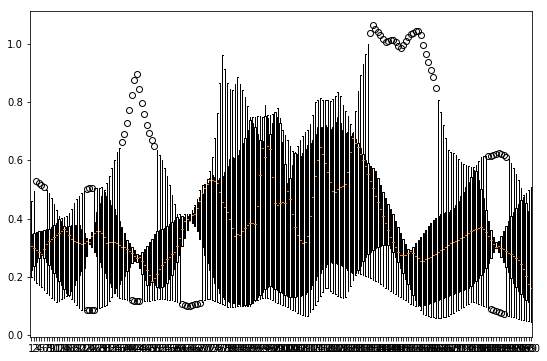

In [18]:
nbValues=200

feature = ResampleFeature(nb_points=nbValues)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF  
qb = QuickBundles(threshold=10,metric=metric)
qb.max_nb_clusters = 1

hue = [0.0, 0.0]  # red only
saturation = [0.0, 1.0]  # white to red
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)

ren = window.ren()

## Boucle sur les sujets

for STR_FX in ['cc_parietal']:    
    resu_FA=np.empty([0,nbValues])
    list_FA=[]
    Cloches_sub=[]
    for SUBJECT in pts_list:    
        TCK_LOCATION=FS_=FS_PATH+SUBJECT+'''/dti/'''
        if os.path.exists(TCK_LOCATION+STR_FX+".dpy"):
            dpw = dp.io.dpy.Dpy(TCK_LOCATION+STR_FX+".dpy", 'r')
            tracks=dpw.read_tracks();
            print(TCK_LOCATION+" "+STR_FX +" "+str(len(tracks)))                
            if (len(tracks)>0):
                cluster = qb.cluster(tracks)                
            else:
                break
            if os.path.exists(TCK_LOCATION+"dti_finalcor_FA.nii"):
                data, affine = load_nifti(TCK_LOCATION+"dti_finalcor_FA.nii")                    
                cluster_native = transform_streamlines(cluster.centroids, np.linalg.inv(affine))       
                x = np.linspace(1, data.shape[0], data.shape[0])
                y = np.linspace(1, data.shape[1], data.shape[1])
                z = np.linspace(1, data.shape[2], data.shape[2])
                my_interpolating_function = RegularGridInterpolator((x, y, z), data)
                tmp=my_interpolating_function(cluster_native)
                resu_FA=np.concatenate((resu_FA, tmp), axis=0)
                list_FA.append(SUBJECT+'_'+STR_FX)
            else: 
                break
        else:
            print(SUBJECT+" "+STR_FX +" No tracks")
    pval_FA=[]
    for cpt1 in range(len(pts_list)):
        for cpt2 in range(len(list_FA)):
            if pts_list[cpt1] in list_FA[cpt2]:
                Cloches_sub.append(Cloches[cpt1])
    print(resu_FA.shape)
    print(len(Cloches_sub))
    for cpt in range(resu_FA.shape[1]):
        rho,pval=stats.spearmanr(Cloches_sub,resu_FA[:,cpt],axis=0) 
        pval_FA.append(pval)
    
    ren.add(actor.line(cluster_native,pval_FA,linewidth=1,lookup_colormap=lut_cmap))

bar2 = actor.scalar_bar(lut_cmap)
ren.add(bar2)
surface_opacity = 0.1
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
window.show(ren)            
            
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(resu_FA)
plt.show()

[0.21516994256955005, 0.45018485575210093, 0.45018485575210093, 0.45018485575210093, 0.58109067282171079, 0.71768564421078607, 0.21516994256955005, 0.85794461760509932, 0.71768564421078607, 0.85794461760509932, 0.85794461760509932, 0.71768564421078607, 0.71768564421078607, 0.85794461760509932, 0.85794461760509932, 0.45018485575210093, 0.45018485575210093, 0.45018485575210093, 0.11761376087345808, 0.11761376087345808]


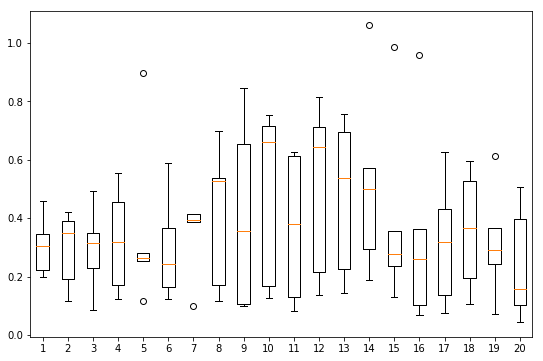

In [17]:
print(pval_FA)
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(resu_FA)
plt.show()

In [26]:
hue = [0.0, 0.0]  # red only
saturation = [0.0, 1.0]  # white to red
lut_cmap = actor.colormap_lookup_table(hue_range=hue,saturation_range=saturation)

#streams, hdr = load_trk(FS_PATH+"slf_ii.left.trk")
streams, hdr = load_trk('/home/romain/Téléchargements/tracks/association/SLF_L.trk.gz')
fix_tracks = Streamlines(streams)

ren = window.ren()
data, affine = load_nifti("/home/global/fsl5011/data/standard/MNI152_T1_1mm_brain.nii.gz")      
ren.add(actor.line(fix_tracks,window.colors.white,linewidth=0.1))
fix_tracks_MNI = transform_streamlines(fix_tracks,np.linalg.inv(affine))
ren.add(actor.line(fix_tracks_MNI,window.colors.white,linewidth=0.1))
surface_opacity = 0.1
surface_color = [0.75, 0.75, 0.75]
v = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]])
ren.add(actor.contour_from_roi(data,affine,surface_color, surface_opacity))
ren.add(actor.contour_from_roi(data,v,surface_color, surface_opacity))
window.show(ren) 